In [19]:
import sys
sys.path.append('..')
import itertools, copy
import json
import numpy as np
import scipy.misc
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('../peptidome.mplstyle')

from lib import *
from base import *

In [20]:
output = True
aas_arr = np.array(list(aminoacids))
N = 4
seed = 1234
prng = np.random.RandomState(seed)


In [21]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]
train, test = train_test_split(humanseqs, test_size=0.5)


In [4]:
# evaluate empirical observables for fitting
df0 = count(train, 1)
df1 = count(train, 2, gap=0)
dfgap1 = count(train, 2, gap=1)
dfgap2 = count(train, 2, gap=2)

In [5]:
h, Jk = fit_potts(df0, [df1, dfgap1, dfgap2], nmcmc=1e6, niter=30, epsilon=0.1, prng=prng, output=output, N=N)

[ 0.45400779 -0.66050852  0.05611162  0.46870351 -0.20250439  0.39748563
 -0.52087632 -0.03259483  0.25030339  0.80545478 -0.74174209 -0.21726625
  0.35364766  0.07429697  0.23695342  0.62506977  0.17829996  0.29101695
 -1.30176657 -0.51409249]
iteration 0
f1 1.548136412473544e-06
f2, gap 0 0.002401566853782732
f2, gap 1 0.0018014411864347973
f2, gap 2 0.0019662817228899058
iteration 1
f1 2.6460712837714895e-06
f2, gap 0 0.0020081820945886814
f2, gap 1 0.0015029653544621014
f2, gap 2 0.0016196840151457676
iteration 2
f1 5.644796886231619e-06
f2, gap 0 0.001593894769203269
f2, gap 1 0.0011119418518341444
f2, gap 2 0.0012559946365008322
iteration 3
f1 4.9896998263220985e-06
f2, gap 0 0.0012959723035681327
f2, gap 1 0.0009880889623188655
f2, gap 2 0.001093922169590812
iteration 4
f1 5.6958500904870736e-06
f2, gap 0 0.0010616233306976392
f2, gap 1 0.0007901491994967216
f2, gap 2 0.0009664777109721381
iteration 5
f1 4.852053641590939e-06
f2, gap 0 0.000861826237087767
f2, gap 1 0.0006929872

In [6]:
k = 4
df4 = count(train, k)
df4 = df4.merge(count(test, k), right_index=True, left_index=True, suffixes=['_train', '_test'])
jsd_test = calc_jsd(df4['freq_train'], df4['freq_test'])
jsd_flat = calc_jsd(df4['freq_test'], np.ones_like(df4['freq_test']))

In [7]:
with open('../../data/triplet-human.json', 'r') as f:
    tripletparams = json.load(f)
kmers = df4.index
df4['freq_ind'] = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
df4['freq_mc'] = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
df4['freq_tri'] = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
jsd_ind = calc_jsd(df4['freq_test'], df4['freq_ind'])
jsd_mc = calc_jsd(df4['freq_test'], df4['freq_mc'])
jsd_tri = calc_jsd(df4['freq_test'], df4['freq_tri'])

In [8]:
q = len(aminoacids)
Z = np.exp(scipy.special.logsumexp([-clib.energy(np.array(s), h, Jk) for s in itertools.product(range(q), repeat=k)]))
df4['freq_maxent'] = np.exp([-clib.energy(map_aatonumber(s), h, Jk) for s in kmers])/Z
jsd_maxent = calc_jsd(df4['freq_test'], df4['freq_maxent'])

In [9]:
print('flat', jsd_flat, 'ind', jsd_ind, 'mc', jsd_mc, 'model', jsd_maxent, 'tri', jsd_tri, 'test', jsd_test, )

flat 0.11000058339844129 ind 0.019343485765939982 mc 0.01307517982350593 model 0.009142299971584104 tri 0.00867386621822569 test 0.007527760831336014


In [1]:
q = len(aminoacids)
N = 4
nmcmc = 1e6
prng = np.random
def jump(x):
    return prng.randint(q, size=N)
def energy(x):
    return clib.energy(x, h, Jk)
x0 = jump(None)
samples = mcmcsampler(x0, energy, jump, nmcmc)
samples = [''.join(aas_arr[s]) for s in samples]

NameError: name 'aminoacids' is not defined

0.0056646042369886815

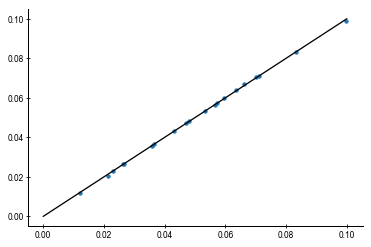

In [11]:
dfm0 = df0.merge(count(samples, 1), left_index=True, right_index=True)
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])
dfm0['logfold'] = np.log(dfm0['freq_x']/dfm0['freq_y'])
np.abs(dfm0['logfold']).mean()

0.019856011693173588

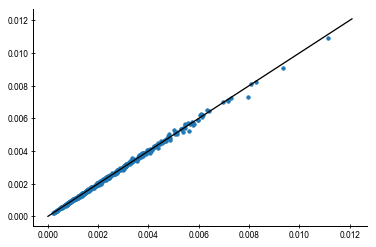

In [12]:
dfm1 = df1.merge(count(samples, 2), left_index=True, right_index=True)
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.022609933480723373

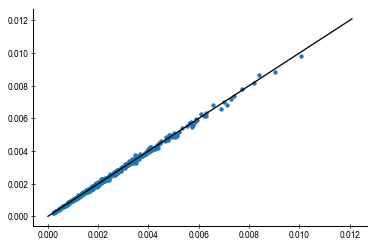

In [13]:
dfmgap1 = dfgap1.merge(count(samples, 2, gap=1), left_index=True, right_index=True)
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

0.029568890847527802

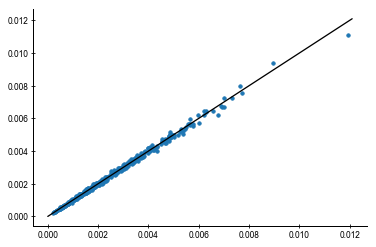

In [14]:
dfmgap2 = dfgap2.merge(count(samples, 2, gap=2), left_index=True, right_index=True)
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap2['freq_x'], dfmgap2['freq_y'])
dfmgap2['logfold'] = np.log(dfmgap2['freq_x']/dfmgap2['freq_y'])
np.abs(dfmgap2['logfold']).mean()

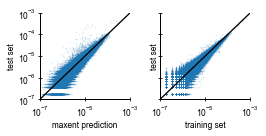

In [15]:
fig, axes = plt.subplots(figsize=(3.8, 2.0), ncols=2, sharex=True, sharey=True)
ax = axes[0]
ax.scatter(df4['freq_maxent'], df4['freq_test'], s=0.5, label='maxent', alpha=.1)
ax.set_xlabel('maxent prediction')
ax.set_ylabel('test set')
ax = axes[1]
ax.scatter(df4['freq_train'], df4['freq_test'], s=0.5, label='train', alpha=.1)
ax.set_xlabel('training set')
ax.set_ylabel('test set')
x = np.logspace(-7, -3)
for ax in axes:
    ax.plot(x, x, 'k')
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    #plt.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('4mer-comparison.png', dpi=600)

In [16]:
dfJk = [pd.DataFrame.from_dict(J) for J in Jk]

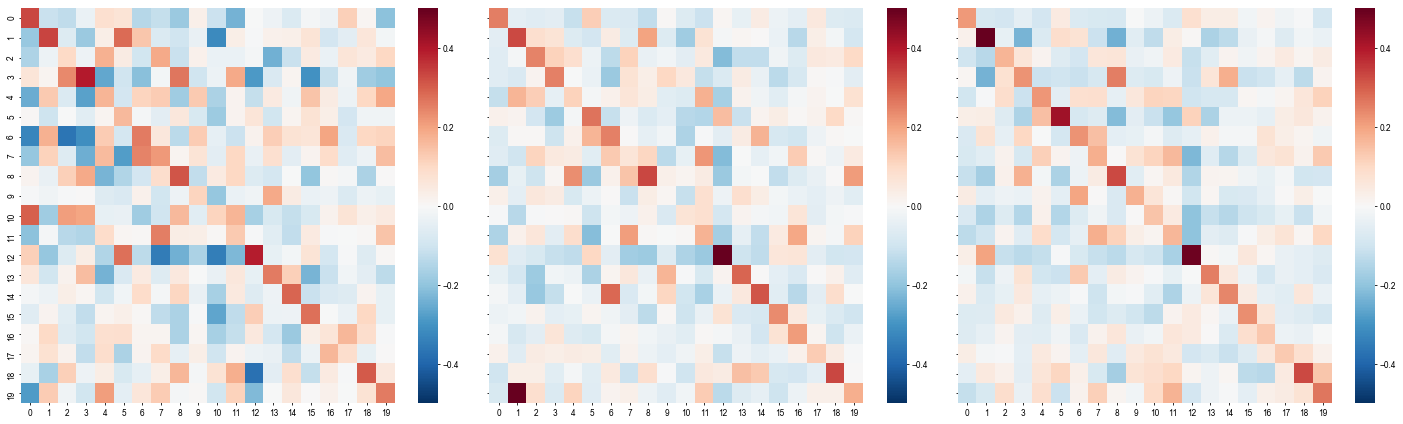

In [17]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=len(dfJk), sharex=True, sharey=True)
for i, dfJ in enumerate(dfJk):
    sns.heatmap(dfJ, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=axes[i])
fig.tight_layout()

In [18]:
k = 5
#kmers = list(itertools.product(aminoacids, repeat=k))
df = counter_to_df(count_kmers_proteome(human, k))
df = df[~df['seq'].str.contains('U|B|X|Z')]
df = df.set_index('seq')
kmers = df.index
exp = np.array([float(df.loc[''.join(s)]) for s in kmers])
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=k)]))
ising = np.exp([-energy_ising(s, h, Jk) for s in kmers])/Z
tri = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
mc = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
ind = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
rising = np.corrcoef(ising, exp)[1, 0]
rind = np.corrcoef(ind, exp)[1, 0]
rtri = np.corrcoef(tri, exp)[1, 0]
rtri, rising, np.corrcoef(mc, exp)[1, 0], rind

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1, label='independent, r=%1.2f'%rind)
#plt.scatter(mc, exp, s=1)
plt.scatter(tri, exp, s=1, label='tri, r=%1.2f'%rtri)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.legend()
plt.xscale('log')
plt.yscale('log')
fig.tight_layout()
fig.savefig('plots/modelfits-4mer-tri.png', dpi=300)

In [ ]:
pd.DataFrame(index=[key for key in h], data=[h[key] for key in h], columns=['h'])

In [ ]:
plot_sorted(df['count'])

In [ ]:
doublets = [''.join(s) for s in itertools.product(list(aminoacids), repeat=2)]

In [ ]:
df = pd.DataFrame(index=doublets, data=[Jk[0][s[0]][s[1]] for s in doublets], columns=['J0'])
for i in range(1, len(Jk)):
    df['J%g'%i] = [Jk[i][s[0]][s[1]] for s in doublets]

In [ ]:
from functools import reduce

In [ ]:
df

In [ ]:
reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), [pd.DataFrame.from_dict(
    {i+j: Jk[gap][i][j] for i in Jk[gap].keys() for j in Jk[gap][i].keys()},
    orient='index')
           for gap in range(len(Jk))])

In [ ]:
pd.merge?